In [ ]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from scipy.stats import spearmanr

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Data importation
df = pd.read_csv("/content/ObesityDataSet_raw_and_data_sinthetic.csv")
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [ ]:
#Check for missing values
df.isnull().sum()

,0
Gender,0
Age,0
Height,0
Weight,0
family_history_with_overweight,0
FAVC,0
FCVC,0
NCP,0
CAEC,0
SMOKE,0


In [ ]:
#Feature encoding for categorical features
df["Gender"] = df["Gender"].map({"Female":0, "Male":1})
df["family_history_with_overweight"] = df["family_history_with_overweight"].map({"yes":1,"no":0})
df["FAVC"] = df["FAVC"].map({"yes":1,"no":0})
df["CAEC"] = df["CAEC"].map({"no":0,"Sometimes":1,"Frequently":2,"Always":3})
df["SMOKE"] = df["SMOKE"].map({"yes":1,"no":0})
df["SCC"] = df["SCC"].map({"yes":1,"no":0})
df["CALC"] = df["CALC"].map({"no":0,"Sometimes":1,"Frequently":2,"Always":3})
df["MTRANS"] = df["MTRANS"].map({"Automobile":0, "Bike":1, "Motorbike":2, "Public_Transportation": 3, "Walking":4})
df["Obesity"] = df["NObeyesdad"].map({"Insufficient_Weight": 0,"Normal_Weight": 1,"Overweight_Level_I": 2,"Overweight_Level_II": 3,"Obesity_Type_I": 4,"Obesity_Type_II": 5,"Obesity_Type_III": 6})
#Remove NObeyesdad
clean = df.drop("NObeyesdad", axis =1)
#View the first 5 rows
clean.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,3,1
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,3,1
2,1,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,3,1
3,1,27.0,1.80,87.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,4,2
4,1,22.0,1.78,89.8,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,3,3


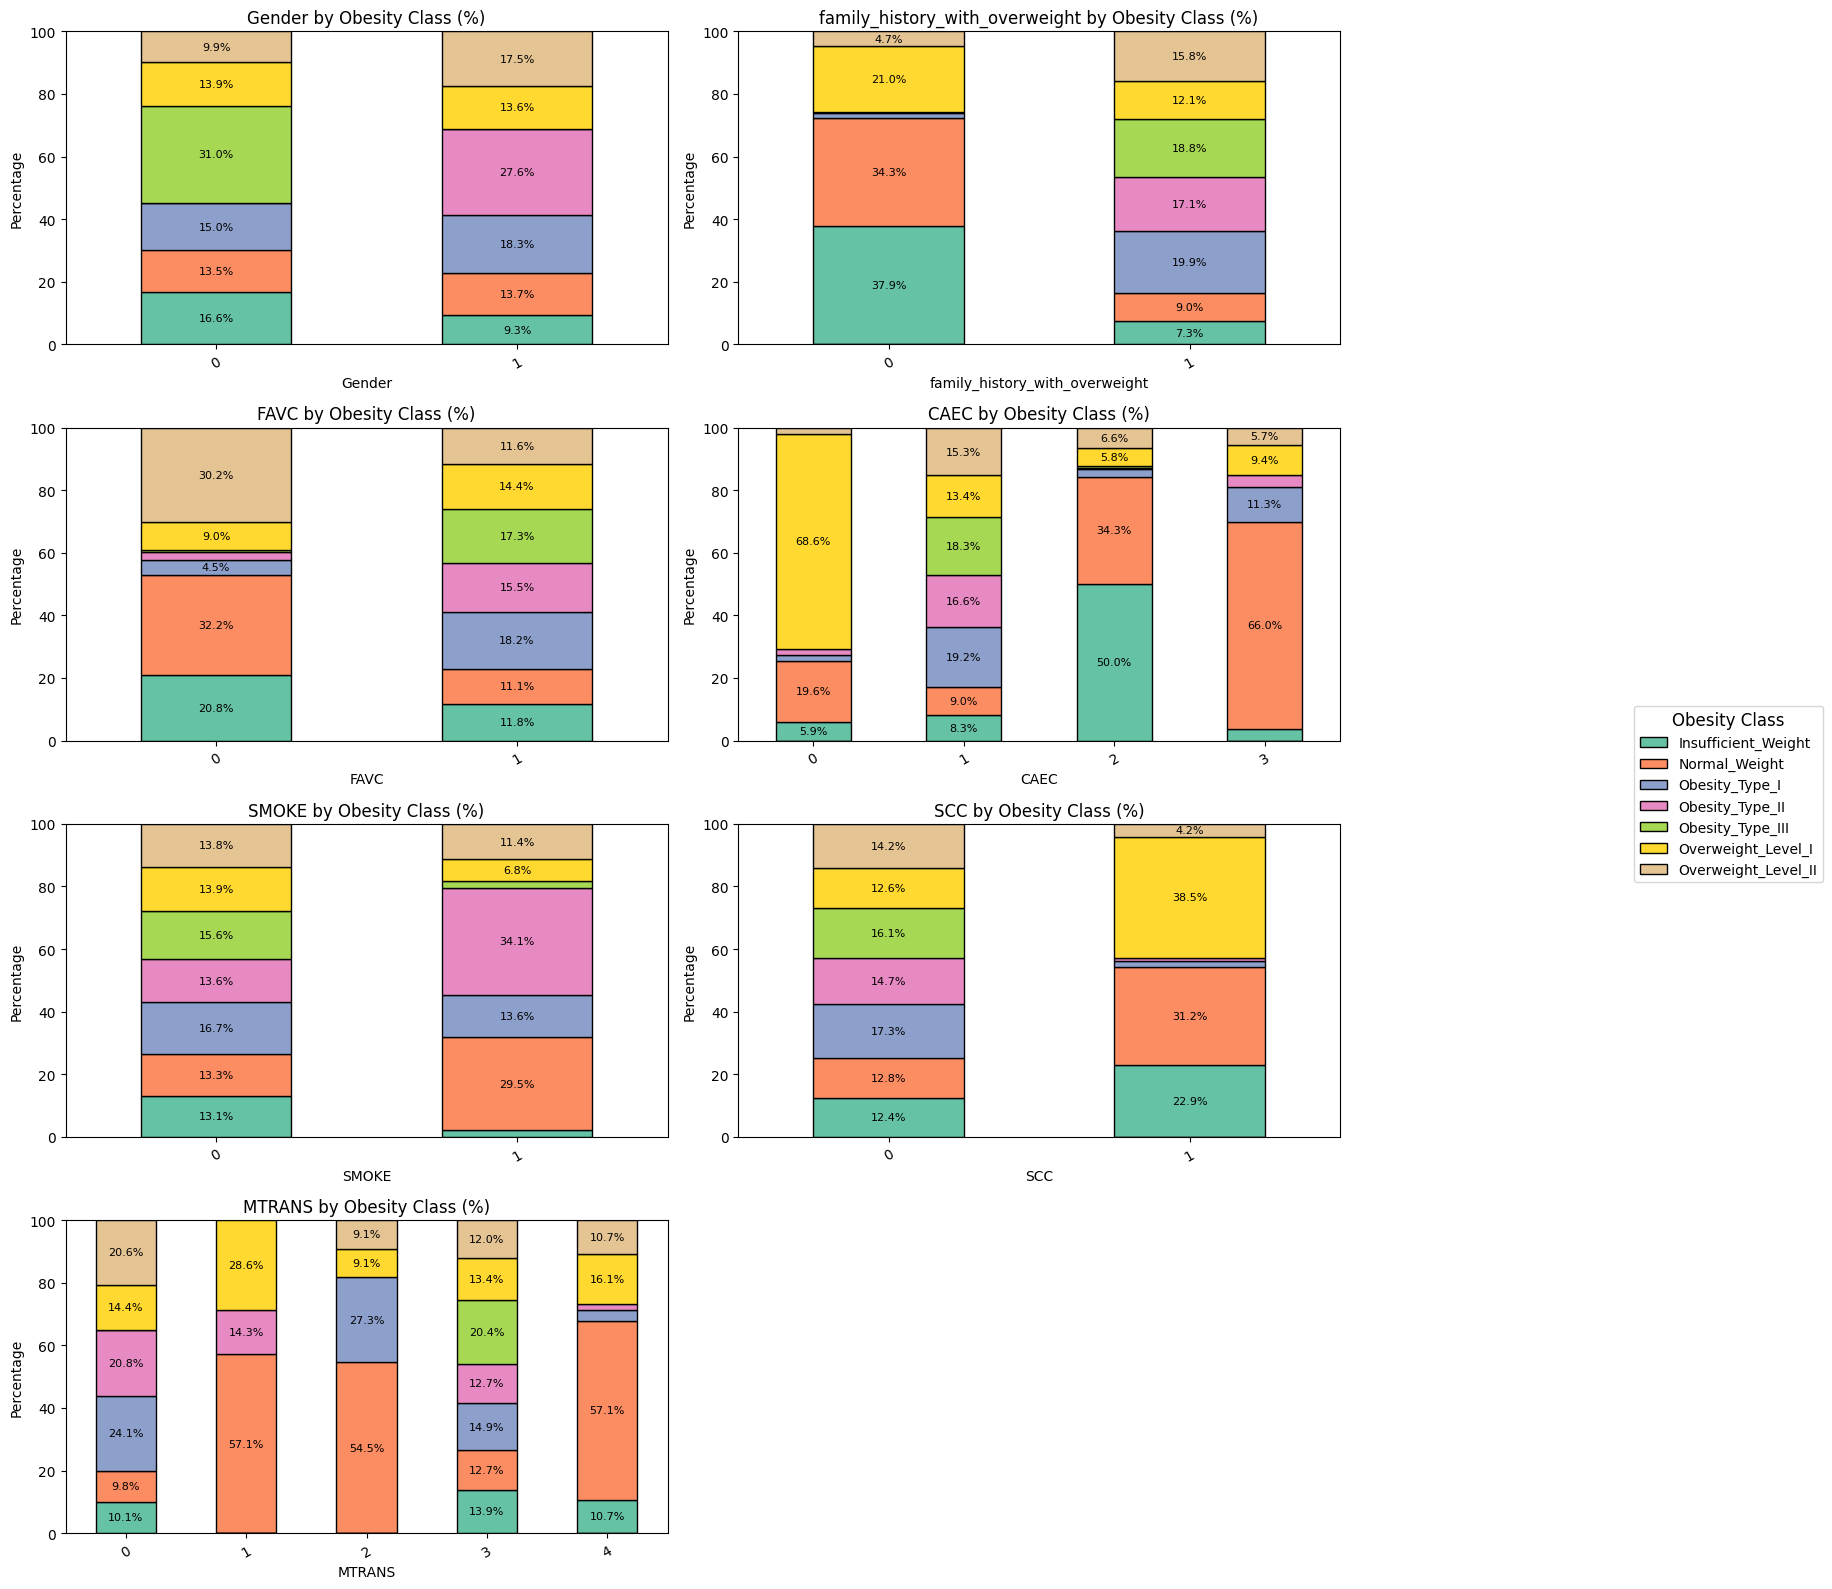

In [ ]:
# ----------------------------------------------
# ✅ Map your target labels
# ----------------------------------------------
target_labels = {
    0: "Insufficient_Weight",
    1: "Normal_Weight",
    2: "Overweight_Level_I",
    3: "Overweight_Level_II",
    4: "Obesity_Type_I",
    5: "Obesity_Type_II",
    6: "Obesity_Type_III"
}
clean['Obesity_Label'] = clean['Obesity'].map(target_labels)
# ----------------------------------------------
# ✅ Your categorical features
# ----------------------------------------------
categorical_features = [
    "Gender",
    "family_history_with_overweight",
    "FAVC",
    "CAEC",
    "SMOKE",
    "SCC",
    "MTRANS"
]

# ----------------------------------------------
# ✅ Define custom Seaborn color palette
# ----------------------------------------------
palette = sns.color_palette("Set2", n_colors=len(target_labels))

# ----------------------------------------------
# ✅ Subplot grid
# ----------------------------------------------
num_features = len(categorical_features)
rows = (num_features + 1) // 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
axes = axes.flatten()

# ----------------------------------------------
# ✅ Loop over features
# ----------------------------------------------
for idx, feature in enumerate(categorical_features):
    ct = pd.crosstab(
        clean[feature],
        clean['Obesity_Label'],
        normalize='index'
    ) * 100

    ax = axes[idx]
    bars = ct.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        color=palette,
        edgecolor='black',
        legend=False
    )
    ax.set_title(f'{feature} by Obesity Class (%)', fontsize=12)
    ax.set_ylabel('Percentage')
    ax.set_xlabel(feature)
    ax.set_ylim(0, 100)
    ax.tick_params(axis='x', rotation=30)

    # Add percentage labels inside bars
    for container in bars.containers:
        for bar in container:
            height = bar.get_height()
            if height > 4:  # Only label larger segments
                ax.annotate(
                    f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                    ha='center',
                    va='center',
                    fontsize=8,
                    color='black'
                )

# ----------------------------------------------
# ✅ Remove empty axes
# ----------------------------------------------
for j in range(len(axes)):
    if j >= num_features:
        fig.delaxes(axes[j])
# ----------------------------------------------
# ✅ One clean global legend outside the plots
# ----------------------------------------------
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title='Obesity Class',
    bbox_to_anchor=(1.02, 0.5),
    loc='center left',
    fontsize=10,
    title_fontsize=12
)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space for legend
plt.show()

Obesity
Insufficient_Weight    272
Normal_Weight          287
Overweight_Level_I     290
Overweight_Level_II    290
Obesity_Type_I         351
Obesity_Type_II        297
Obesity_Type_III       324
Name: count, dtype: int64


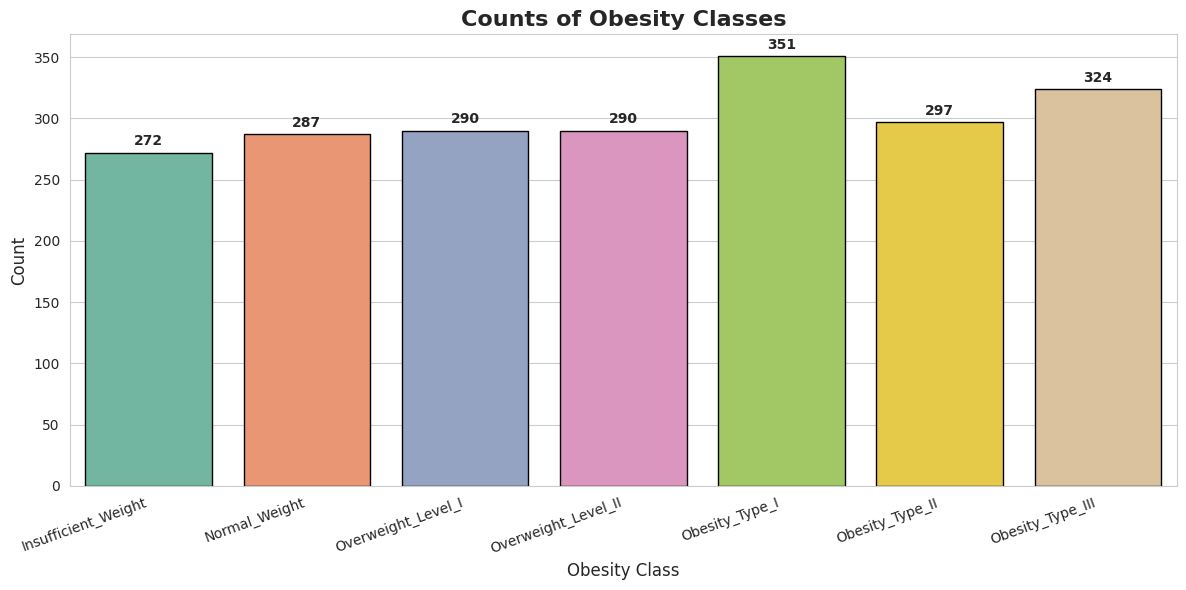

In [ ]:
# ----------------------------------------------
# ✅ Define the mapping
# ----------------------------------------------
target_labels = {
    0: "Insufficient_Weight",
    1: "Normal_Weight",
    2: "Overweight_Level_I",
    3: "Overweight_Level_II",
    4: "Obesity_Type_I",
    5: "Obesity_Type_II",
    6: "Obesity_Type_III"
}

# ----------------------------------------------
# ✅ Get the counts and map labels
# ----------------------------------------------
value_counts = clean['Obesity'].value_counts().sort_index()
value_counts.index = value_counts.index.map(target_labels)
print(value_counts)

# ----------------------------------------------
# ✅ Plot: Clean barplot
# ----------------------------------------------
sns.set_style("whitegrid")  # subtle grid
plt.figure(figsize=(12, 6))

# Barplot with nicer palette
sns.barplot(
    x=value_counts.index,
    y=value_counts.values,
    palette='Set2',
    edgecolor='black'
)

# Titles and labels
plt.title('Counts of Obesity Classes', fontsize=16, weight='bold')
plt.xlabel('Obesity Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=20, ha='right', fontsize=10)
# Add counts on top of each bar
for idx, count in enumerate(value_counts.values):
    plt.text(
        idx,
        count + (max(value_counts.values) * 0.01),
        f'{count:,}',  # add comma for big numbers
        ha='center',
        va='bottom',
        fontsize=10,
        weight='bold'
    )
plt.tight_layout()
plt.show()


Bins used: [0, 18, 29, 39, 62.0]

Example Age Groups:
     Age Age_Group
0  21.0     19-29
1  21.0     19-29
2  23.0     19-29
3  27.0     19-29
4  22.0     19-29
5  29.0     19-29
6  23.0     19-29
7  22.0     19-29
8  24.0     19-29
9  22.0     19-29

Group counts:
 Age_Group
0-18      241
19-29    1474
30-39     316
40+        80
Name: count, dtype: int64


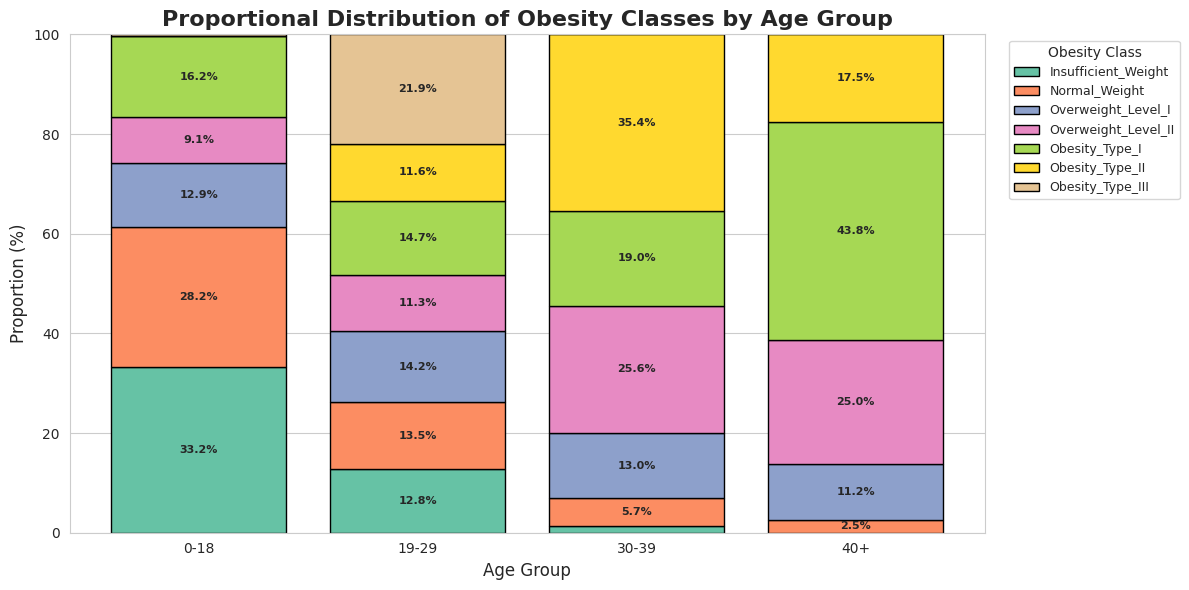

In [ ]:
# ---------------------------------------------------------
# ✅ Define obesity class label mapping
# ---------------------------------------------------------
target_labels = {
    0: "Insufficient_Weight",
    1: "Normal_Weight",
    2: "Overweight_Level_I",
    3: "Overweight_Level_II",
    4: "Obesity_Type_I",
    5: "Obesity_Type_II",
    6: "Obesity_Type_III"
}
clean['Obesity_Label'] = clean['Obesity'].map(target_labels)

# ---------------------------------------------------------
# ✅ Define new age bins: 0-18, 19-29, 30-39, 40+
# ---------------------------------------------------------
actual_max_age = clean['Age'].max()
bins = [0, 18, 29, 39, max(40, actual_max_age + 1)]
labels = ['0-18', '19-29', '30-39', '40+']

clean['Age_Group'] = pd.cut(
    clean['Age'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)

print("\nBins used:", bins)
print("\nExample Age Groups:\n", clean[['Age', 'Age_Group']].head(10))
print("\nGroup counts:\n", clean['Age_Group'].value_counts().sort_index())

# ---------------------------------------------------------
# ✅ Compute proportions for each age group and obesity class
# ---------------------------------------------------------
age_group_dist = (
    clean.groupby(['Age_Group', 'Obesity_Label'])
    .size()
    .reset_index(name='Count')
)
age_group_totals = age_group_dist.groupby('Age_Group')['Count'].transform('sum')
age_group_dist['Proportion'] = age_group_dist['Count'] / age_group_totals * 100

# Pivot for stacked plot
pivot = age_group_dist.pivot(
    index='Age_Group',
    columns='Obesity_Label',
    values='Proportion'
).fillna(0)

# Keep consistent obesity class order
pivot = pivot[target_labels.values()]

# ---------------------------------------------------------
# ✅ Plot: Improved stacked proportional bar chart
# ---------------------------------------------------------
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))

bottom = [0] * len(pivot)
colors = sns.color_palette("Set2", n_colors=len(pivot.columns))

# Draw each stack manually for more control
for idx, obesity_class in enumerate(pivot.columns):
    values = pivot[obesity_class].values
    bars = ax.bar(
        pivot.index,
        values,
        bottom=bottom,
        label=obesity_class,
        color=colors[idx],
        edgecolor='black'
    )

    # Add % labels to each segment if large enough
    for i, (b, v) in enumerate(zip(bottom, values)):
        if v > 2:
            ax.text(
                i,
                b + v / 2,
                f"{v:.1f}%",
                ha='center',
                va='center',
                fontsize=8,
                weight='bold'
            )

    # Update bottom for next stack
    bottom = [b + v for b, v in zip(bottom, values)]

# Styling
ax.set_title('Proportional Distribution of Obesity Classes by Age Group',
             fontsize=16, weight='bold')
ax.set_xlabel('Age Group', fontsize=12)
ax.set_ylabel('Proportion (%)', fontsize=12)
ax.set_ylim(0, 100)
ax.tick_params(axis='x', rotation=0)

# Legend outside
ax.legend(
    title='Obesity Class',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=9,
    title_fontsize=10
)
plt.tight_layout()
plt.show()

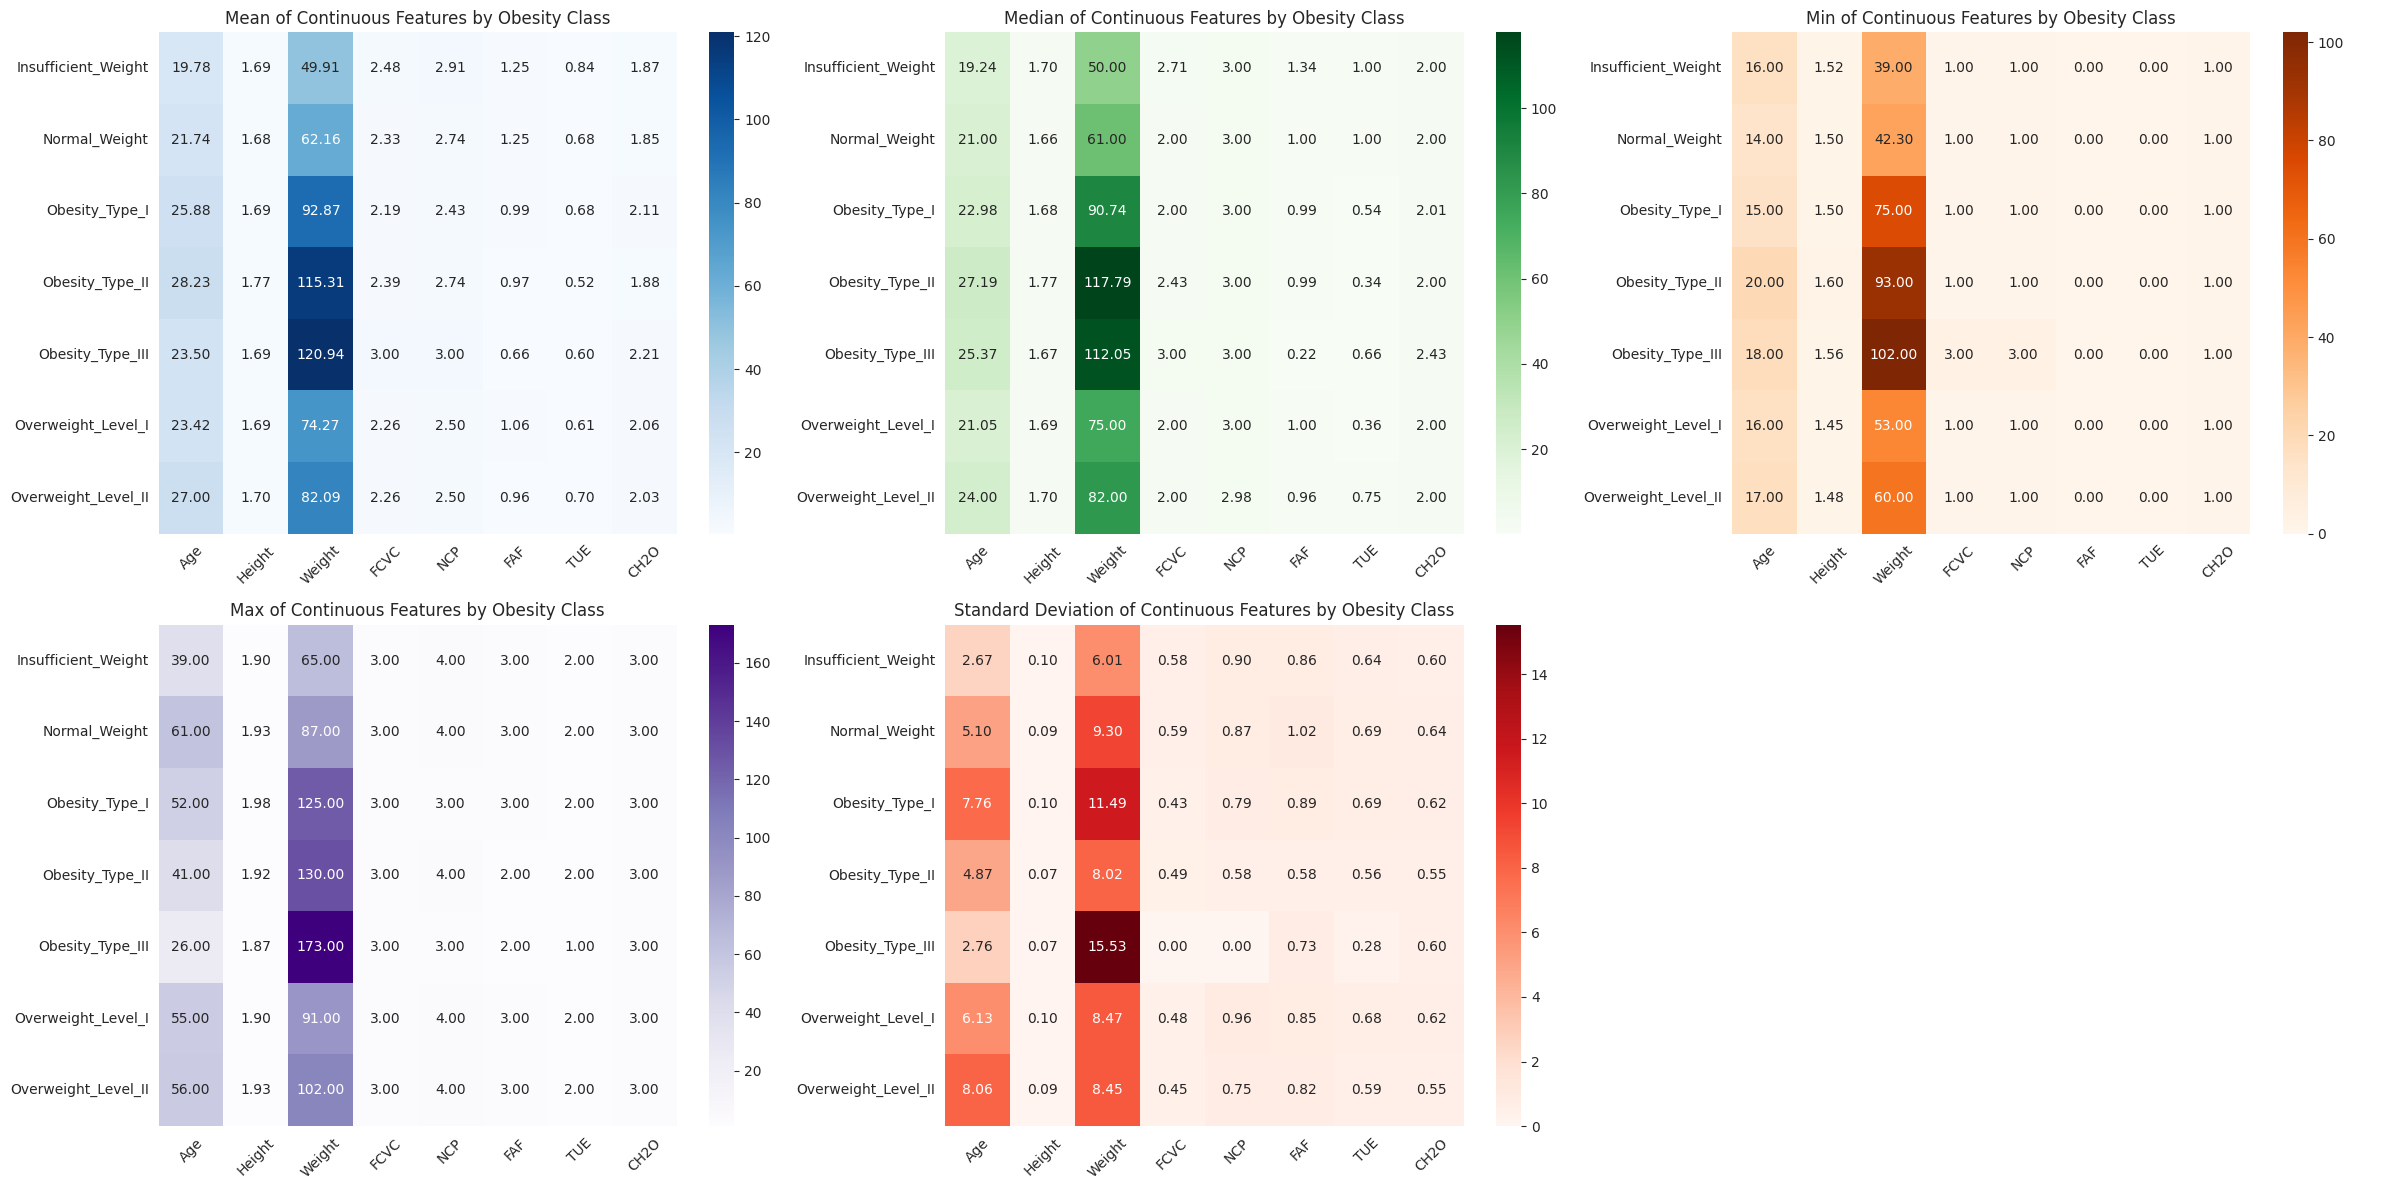

In [ ]:
# ---------------------------------------------
# Group by obesity class and calculate stats
# ---------------------------------------------
continous_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP',  'FAF', 'TUE', 'CH2O']
grouped = clean.groupby('Obesity_Label')[continous_features]
means = grouped.mean()
stds  = grouped.std()
mins  = grouped.min()
maxs  = grouped.max()
medians = grouped.median()  # ✅ Add median
# ---------------------------------------------
# Set up 2×3 subplot grid
# ---------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(24, 12))
sns.heatmap(means, annot=True, fmt=".2f", cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Mean of Continuous Features by Obesity Class')
sns.heatmap(medians, annot=True, fmt=".2f", cmap='Greens', ax=axes[0,1])
axes[0,1].set_title('Median of Continuous Features by Obesity Class')
sns.heatmap(mins, annot=True, fmt=".2f", cmap='Oranges', ax=axes[0,2])
axes[0,2].set_title('Min of Continuous Features by Obesity Class')
sns.heatmap(maxs, annot=True, fmt=".2f", cmap='Purples', ax=axes[1,0])
axes[1,0].set_title('Max of Continuous Features by Obesity Class')
sns.heatmap(stds, annot=True, fmt=".2f", cmap='Reds', ax=axes[1,1])
axes[1,1].set_title('Standard Deviation of Continuous Features by Obesity Class')
# Hide the empty last subplot (axes[1,2])
axes[1,2].axis('off')
# Rotate x-axis labels for all subplots
for ax in axes.flat:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#Drop the unnecessary columns
clean_data = clean.drop(["Obesity_Label","Age_Group"], axis=1)
clean_data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,3,1
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,3,1
2,1,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,3,1
3,1,27.0,1.80,87.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,4,2
4,1,22.0,1.78,89.8,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,3,3


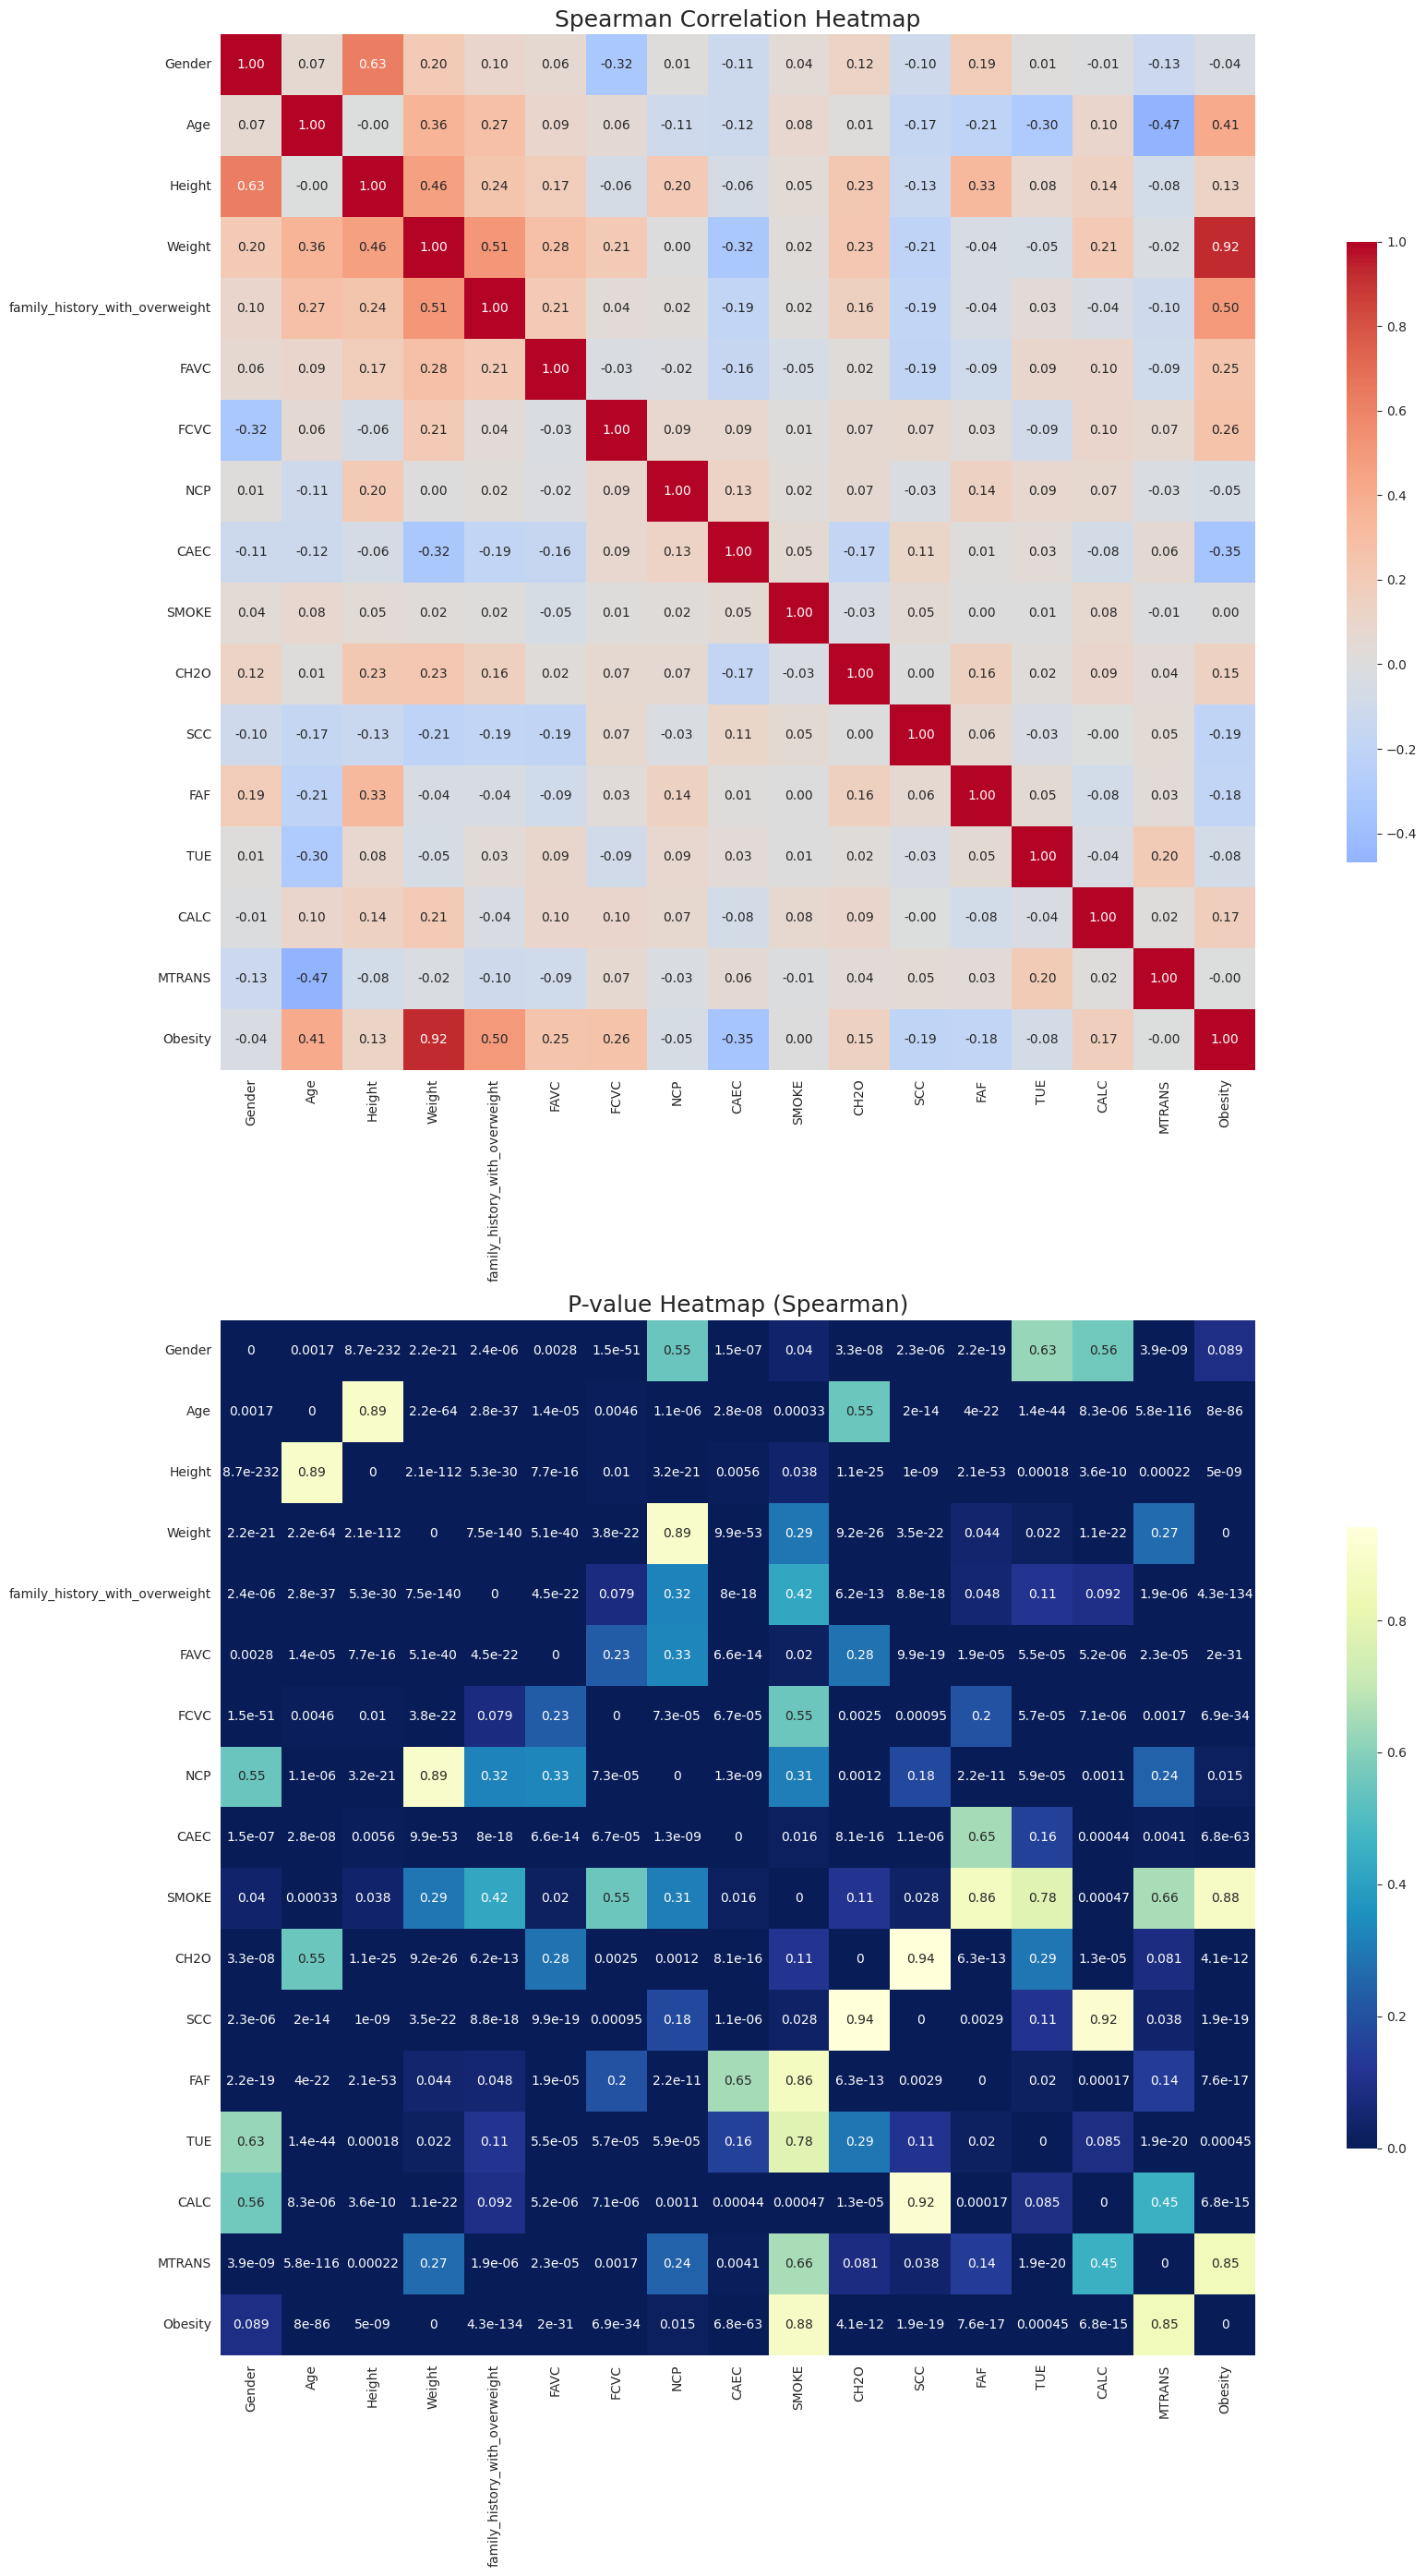

In [ ]:
# Compute Spearman correlation and p-values matrix
corr, pval = spearmanr(clean_data)
# Convert to DataFrames for easier plotting
cols = clean_data.columns
corr_df = pd.DataFrame(corr, index=cols, columns=cols)
pval_df = pd.DataFrame(pval, index=cols, columns=cols)
# Create vertically stacked heatmaps
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 28))  # 2 rows, 1 column
# Spearman Correlation Heatmap
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            square=True, cbar_kws={"shrink": 0.6}, ax=ax1)
ax1.set_title('Spearman Correlation Heatmap', fontsize=18)
# P-value Heatmap
sns.heatmap(pval_df, annot=True, fmt=".2g", cmap='YlGnBu_r',
            square=True, cbar_kws={"shrink": 0.6}, ax=ax2)
ax2.set_title('P-value Heatmap (Spearman)', fontsize=18)
# Final layout adjustment
plt.tight_layout()
plt.show()

Train: (1688, 16) Val: (211, 16) Test: (212, 16)
Class Weights: {np.int64(0): np.float64(1.1061598951507208), np.int64(1): np.float64(1.0530255770430443), np.int64(2): np.float64(1.0394088669950738), np.int64(3): np.float64(1.0394088669950738), np.int64(4): np.float64(0.8581596339603457), np.int64(5): np.float64(1.0174804098854733), np.int64(6): np.float64(0.9310535024820739)}

 FINAL TEST METRICS PER LR

⚡ Training with learning rate: 1e-06

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.0958 - loss: 1.9901 - val_accuracy: 0.1090 - val_loss: 1.9931
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1081 - loss: 1.9849 - val_accuracy: 0.1137 - val_loss: 1.9897
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1235 - loss: 1.9909 - val_accuracy: 0.1232 - val_loss: 1.9863
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1170 - loss: 1.9875 - val_accuracy: 0.1374 - val_loss: 1.9829
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 

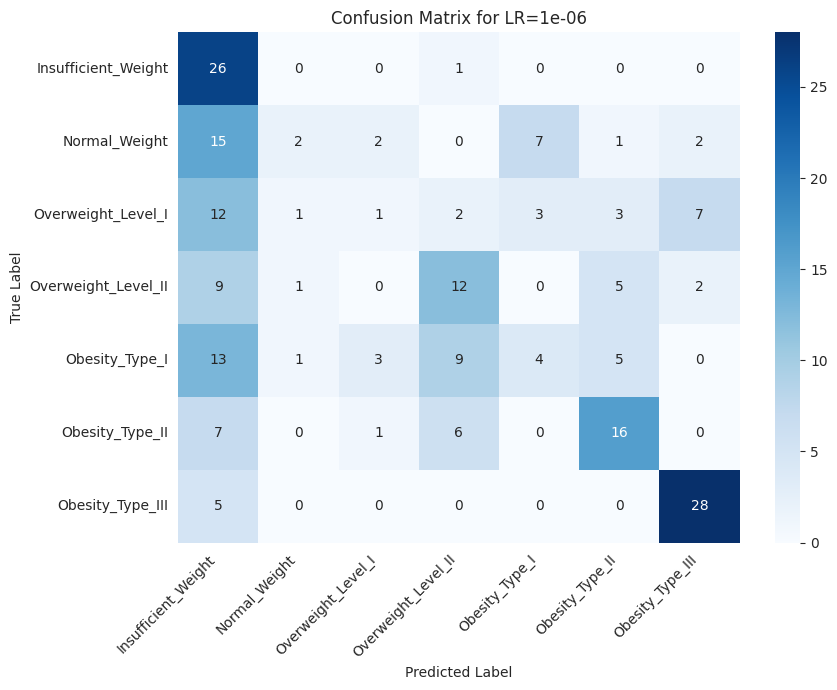

⚡ Training with learning rate: 1e-05

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.1678 - loss: 1.9685 - val_accuracy: 0.2180 - val_loss: 1.9264
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2304 - loss: 1.9247 - val_accuracy: 0.2844 - val_loss: 1.8944
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3109 - loss: 1.8825 - val_accuracy: 0.3175 - val_loss: 1.8638
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3366 - loss: 1.8561 - val_accuracy: 0.3602 - val_loss: 1.8346
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3891 - loss: 1.8398 - val_accuracy: 0.4076 - val_loss: 1.8057
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4058 - loss: 1.8116 - val_accuracy: 0.4408 - val_loss: 1.7775
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4498 - loss: 1.7737 - val_accuracy: 0.4692 - val_loss: 1.7494
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0

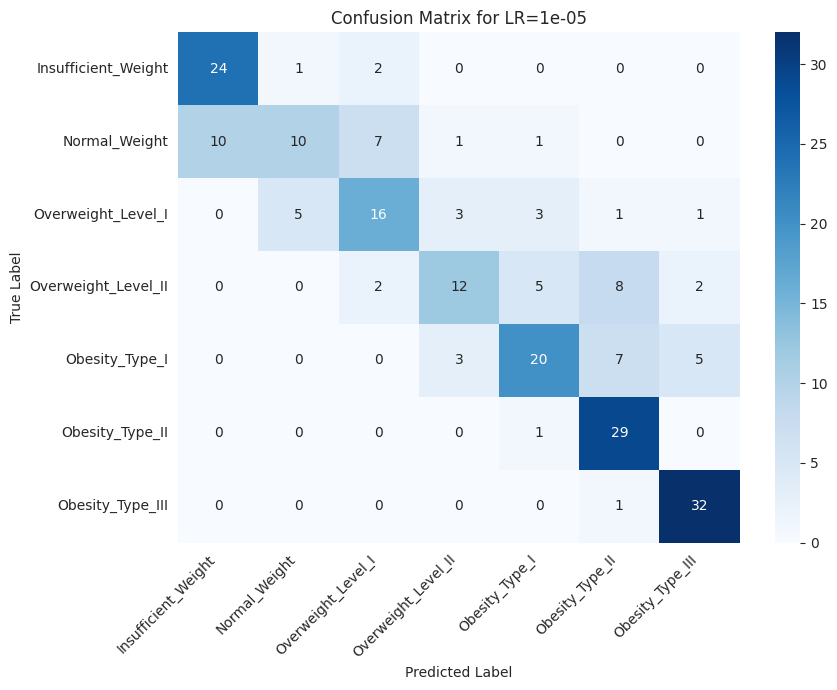

⚡ Training with learning rate: 0.0001

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2070 - loss: 1.8938 - val_accuracy: 0.5166 - val_loss: 1.6620
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5577 - loss: 1.5573 - val_accuracy: 0.6019 - val_loss: 1.3927
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6343 - loss: 1.2844 - val_accuracy: 0.6493 - val_loss: 1.1861
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6668 - loss: 1.1031 - val_accuracy: 0.6919 - val_loss: 1.0428
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7101 - loss: 1.0016 - val_accuracy: 0.7014 - val_loss: 0.9469
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7274 - loss: 0.8875 - val_accuracy: 0.7109 - val_loss: 0.8759
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7585 - loss: 0.7997 - val_accuracy: 0.7346 - val_loss: 0.8142
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 

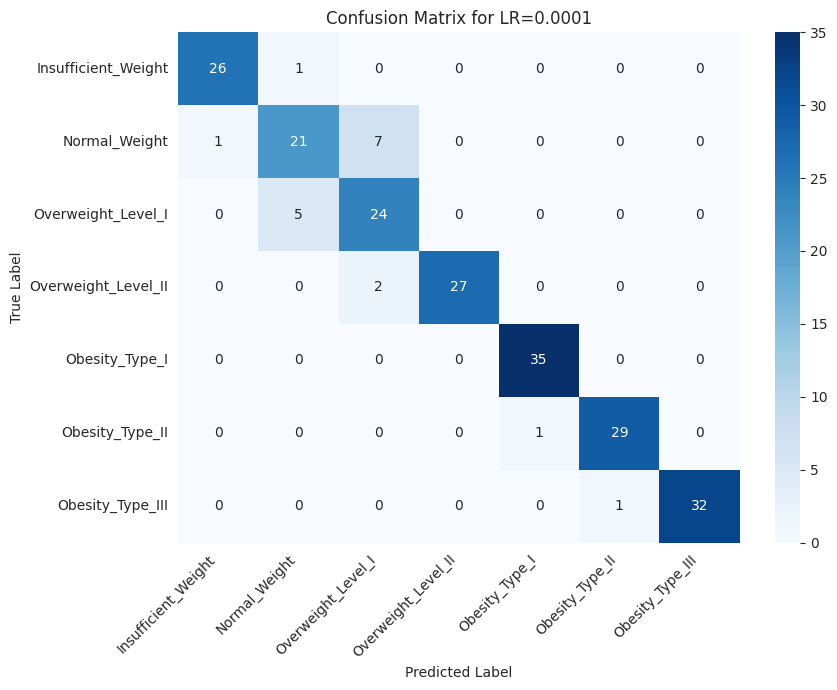

⚡ Training with learning rate: 0.001

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5380 - loss: 1.4049 - val_accuracy: 0.7156 - val_loss: 0.7318
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7833 - loss: 0.6488 - val_accuracy: 0.8104 - val_loss: 0.5255
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8706 - loss: 0.4196 - val_accuracy: 0.8673 - val_loss: 0.3932
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9232 - loss: 0.2768 - val_accuracy: 0.9289 - val_loss: 0.2835
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9329 - loss: 0.2287 - val_accuracy: 0.8673 - val_loss: 0.2966
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9677 - loss: 0.1531 - val_accuracy: 0.9289 - val_loss: 0.2207
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9704 - loss: 0.1223 - val_accuracy: 0.9384 - val_loss: 0.1853
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0

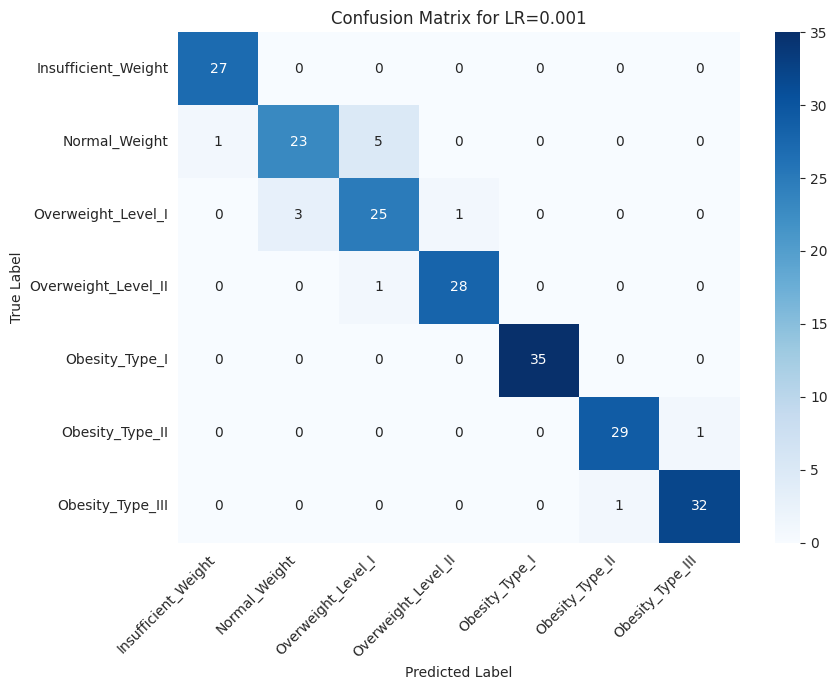

⚡ Training with learning rate: 0.01

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5808 - loss: 1.0641 - val_accuracy: 0.8436 - val_loss: 0.3550
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8875 - loss: 0.3106 - val_accuracy: 0.7915 - val_loss: 0.5621
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8849 - loss: 0.3387 - val_accuracy: 0.8578 - val_loss: 0.3676
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9105 - loss: 0.2747 - val_accuracy: 0.9005 - val_loss: 0.2805
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9341 - loss: 0.2061 - val_accuracy: 0.9194 - val_loss: 0.3737
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9440 - loss: 0.2001 - val_accuracy: 0.8957 - val_loss: 0.4642
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9294 - loss: 0.2137 - val_accuracy: 0.9100 - val_loss: 0.4106
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.

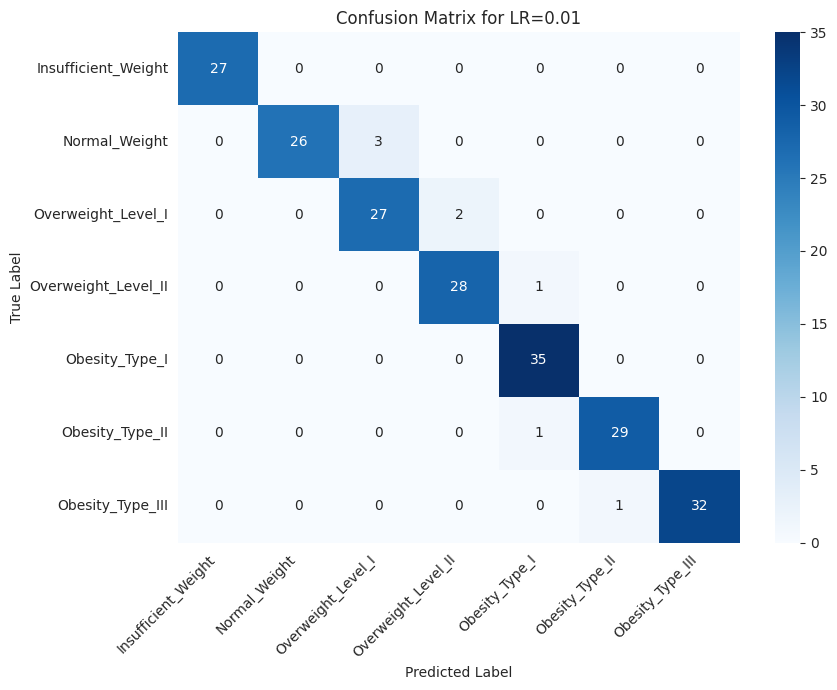

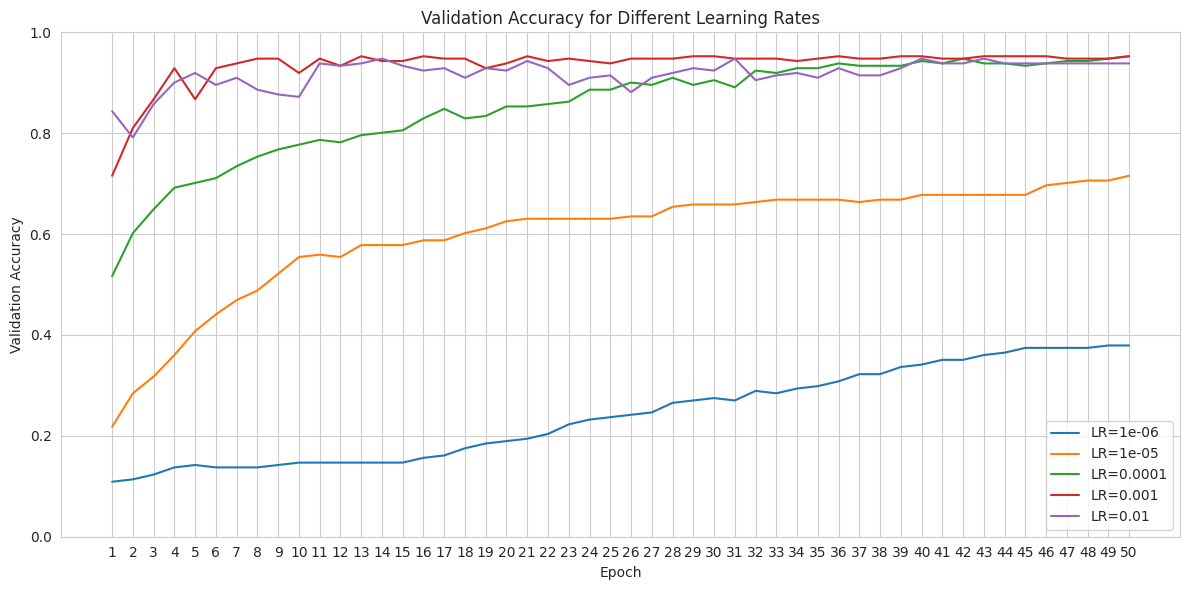

In [ ]:
# =====================================================
# Define your human-readable class labels
# =====================================================
class_labels = [ "Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]
# =====================================================
# Split the dataset
# =====================================================
X = clean_data.drop('Obesity', axis=1)
y = clean_data['Obesity']
# Initial split: 10% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)
# Further split: 80% train, 10% val (from remaining 90%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, random_state=42, stratify=y_temp
)
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
# =====================================================
# Compute class weights on original integer labels
# =====================================================
y_train_int = np.array(y_train)
classes = np.unique(y_train_int)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_int
)
class_weight_dict = dict(zip(classes, class_weights))
print("Class Weights:", class_weight_dict)
# =====================================================
# One-hot encode labels
# =====================================================
y_train_cat = to_categorical(y_train_int, num_classes=7)
y_val_cat   = to_categorical(y_val, num_classes=7)
y_test_cat  = to_categorical(y_test, num_classes=7)
# =====================================================
# Feature scaling
# =====================================================
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)
# Make sure you have X_train_scaled, X_val_scaled, X_test_scaled
# =====================================================
# ANN model builder function
# =====================================================
def build_ann_model(input_dim, learning_rate):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(7, activation='softmax')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model
# =====================================================
# Loop through learning rates & evaluate
# =====================================================
learning_rates = [ 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
histories = {}
print("\n=====================================")
print(" FINAL TEST METRICS PER LR")
print("=====================================\n")

for lr in learning_rates:
    print(f"⚡ Training with learning rate: {lr}\n")
    model = build_ann_model(input_dim=X_train_scaled.shape[1], learning_rate=lr)

    history = model.fit(
        X_train_scaled, y_train_cat,
        epochs=50,
        batch_size= 16,
        validation_data=(X_val_scaled, y_val_cat),
        class_weight=class_weight_dict,
        verbose=1
    )

    histories[lr] = history

    # ✅ Predict on test set
    y_pred_probs = model.predict(X_test_scaled)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    y_true_labels = np.argmax(y_test_cat, axis=1)

    # ✅ Classification Report
    report = classification_report(
        y_true_labels,
        y_pred_labels,
        target_names=class_labels,
        digits=3
    )
    print(f"📊 Classification Report for LR={lr}:\n")
    print(report)

    # ✅ Calculate final metrics
    test_acc = accuracy_score(y_true_labels, y_pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true_labels, y_pred_labels, average='macro'
    )

    print(f"✅ FINAL TEST METRICS for LR={lr}:")
    print(f"  - Accuracy: {test_acc:.3f}")
    print(f"  - Precision (macro): {precision:.3f}")
    print(f"  - Recall (macro): {recall:.3f}")
    print(f"  - F1-score (macro): {f1:.3f}\n")

    # Confusion Matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plt.figure(figsize=(9,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title(f'Confusion Matrix for LR={lr}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
# =====================================================
# Plot Validation Accuracy (no text on plot)
# =====================================================
plt.figure(figsize=(12, 6))

for lr, history in histories.items():
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(val_acc) + 1)
    plt.plot(epochs, val_acc, label=f'LR={lr}')

plt.title('Validation Accuracy for Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)
plt.xticks(epochs)
plt.legend()
plt.tight_layout()
plt.show()